# Identifying Patterns and Hidden Structure in Neural Population Activity

In this final part of the course, our focus shifts to **exploratory data analysis** of the **neural activity traces** we have extracted so far. The core objective is to uncover structure and potential patterns within the ensemble activity — either by relating it to available behavioral data, or by analyzing the organization and co-activity of individual neurons relative to the overall population.
The methods demonstrated here are foundational tools in modern neuroscience for understanding how neuronal ensembles encode, process, or respond to experimental variables and internal states.

While we will primarily use synthetic or population-level surrogates for behavioral data, the analysis strategies are directly transferable to real behavioral experiments.

## Activate the CASCADE environment
To run the code in this notebook, we can use the CASCADE environment that we created in the [previous tutorial](../02_Cascade_tutorial/Calibrated_spike_inference_with_Cascade.ipynb). If you have not done so yet, please follow the instructions in that tutorial to set up the environment.

## Visualize inferred spike probabilities
As a first step, we visualize the inferred spike probabilities for all recorded neurons across time. This provides a global overview of the dynamics within the neural population, and can immediately reveal features such as periods of coordinated activity, bursts, silence, or heterogeneity in neural responses.

We begin by loading the spike probability array — generated previously by the spike inference algorithm — from a CSV file:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# set global properties for all plots:
plt.rcParams.update({'font.size': 14})
plt.rcParams["axes.spines.top"]    = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"]   = False
plt.rcParams["axes.spines.right"]  = False

spike_probs_path = '../02 Cascade tutorial/'
spike_probs_file = 'predictions_Sue_2x_3000_40_-46.csv' # please change this to your own file
spike_probs_fullpath = spike_probs_path + spike_probs_file
spike_probs = np.loadtxt(spike_probs_fullpath, delimiter=',')

print(f'Loaded spike probabilities from {spike_probs_fullpath} with shape {spike_probs.shape}')
print(f"Shape of spike probabilities: {spike_probs.shape}")

Loaded spike probabilities from ../02 Cascade tutorial/predictions_Sue_2x_3000_40_-46.csv with shape (65, 3000)
Shape of spike probabilities: (65, 3000)


This array, `spike_probs`, has the shape (`n_neurons`, `n_timepoints`), with each row representing the activity of a single neuron across the recording session:

Let's inspect a single trace to see how it looks like:

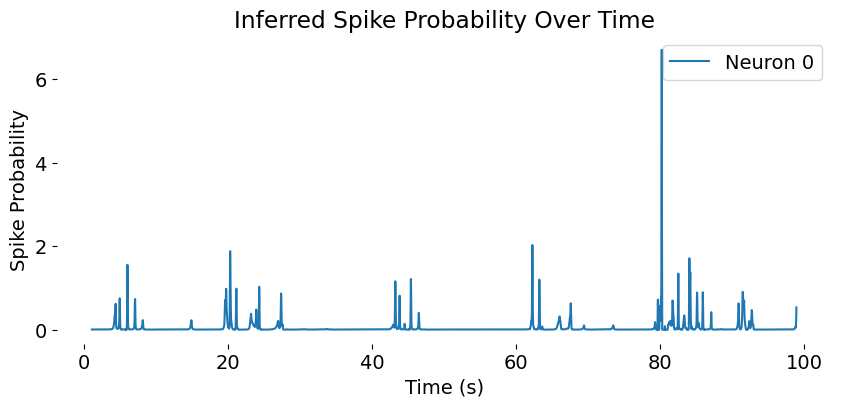

In [136]:
frame_rate = 30  # Hz; please change this to your own frame rate
time_vec = np.arange(spike_probs.shape[1]) / frame_rate

neuron_i = 0  # index of the neuron to plot; change this to plot different neurons
plt.figure(figsize=(10, 4))
plt.plot(time_vec, spike_probs[neuron_i], label=f'Neuron {neuron_i}')
plt.xlabel('Time (s)')
plt.ylabel('Spike Probability')
plt.title('Inferred Spike Probability Over Time')
plt.legend()
plt.show()

Next, we plot all neuronal traces in a single plot, using `imshow`:

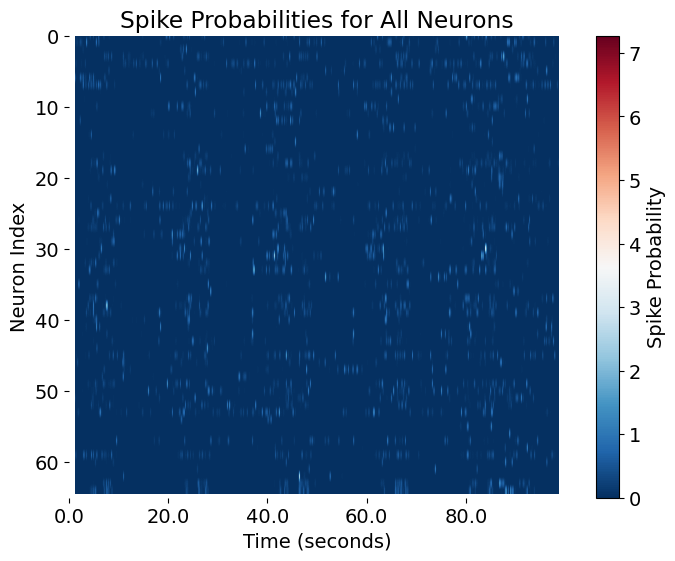

In [134]:
plt.figure(figsize=(8, 6))
plt.imshow(spike_probs, aspect='auto', cmap='RdBu_r', origin='lower')
plt.colorbar(label='Spike Probability')
plt.title('Spike Probabilities for All Neurons')
plt.xlim(0, spike_probs.shape[1])
plt.ylim(0, spike_probs.shape[0])
plt.gca().invert_yaxis()
# change the x-axis ticks to show time in seconds
plt.xticks(ticks=np.arange(0, spike_probs.shape[1], frame_rate * 20), 
           labels=np.arange(0, spike_probs.shape[1] / frame_rate, 20))
plt.xlabel('Time (seconds)')
plt.ylabel('Neuron Index')
#plt.tight_layout()
plt.show()

Visualizing these spike probabilities is a crucial quality control step. It allows you to verify data integrity, spot artifacts, and get a first impression of the richness and diversity of neuronal activity patterns. This approach is standard in computational neuroscience and forms the foundation for downstream analyses such as clustering, dimensionality reduction, or correlation analysis.

### Binning the data
Direct visualization of spike probabilities at the original recording frame rate provides the most detailed view of neuronal activity, but this fine-grained view can also obscure broader patterns due to high-frequency fluctuations and noise. In many cases, we are more interested in the **slow dynamics**, **collective states**, or **recurring motifs** in **population activity** — features that become much clearer when we average or "bin" the data over longer time windows.

**Temporal binning** involves averaging (or summing) the data within fixed time intervals (bins), which **reduces moment-to-moment noise** and **emphasizes trends and co-activity** that occur on slower timescales (slower mean slightly slower than the original sampling rate). This process is conceptually analogous to low-pass filtering or downsampling, and is commonly used to reveal **population dynamics**, **responses to stimuli**, or **behavioral correlations** that may be masked at high temporal resolution.

Binning is particularly valuable when:

* You want to highlight population-level patterns, such as epochs of **elevated or coordinated activity**.
* The precise timing of single spikes is less relevant than the **overall firing rate** or probability **within a behavioral or experimental context**.
* You need to **reduce data dimensionality** for computational efficiency or clarity in visualization.

However, the choice of bin size must be guided by your scientific question:

* **Too small:** You retain noise and obscure global structure.
* **Too large:** You may average away meaningful rapid events.

In this example, we will bin the spike probabilities into windows of *N* seconds to provide a clearer view of network activity and potential temporal structure:

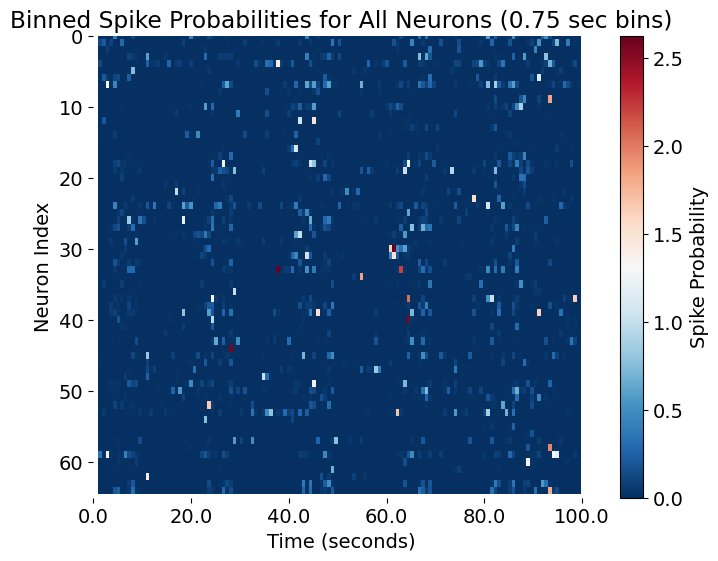

In [ ]:
# temporal binning and visualization

# plot the same plot as above, but no binned for every N seconds
bin_size = 0.75  # in sec - please change this to your desired bin size

# convert bin size to number of frames:
bin_size_frames = int(bin_size * frame_rate)  # convert to number of frames
# bin the spike probabilities:
spike_probs_binned = spike_probs[:, ::bin_size_frames]
plt.figure(figsize=(8, 6))
plt.imshow(spike_probs_binned, aspect='auto', cmap='RdBu_r', origin='lower')
plt.colorbar(label='Spike Probability')
plt.title(f'Binned Spike Probabilities for All Neurons ({bin_size} sec bins)')
plt.xlim(0, spike_probs_binned.shape[1])
plt.ylim(0, spike_probs_binned.shape[0])
plt.gca().invert_yaxis()
# change the x-axis ticks to show time in seconds
plt.xticks(ticks=np.arange(0, spike_probs_binned.shape[1], frame_rate * 20 // bin_size_frames), 
           labels=np.arange(0, spike_probs_binned.shape[1] * bin_size_frames / frame_rate, 20))
plt.xlabel('Time (seconds)')
plt.ylabel('Neuron Index')
#plt.tight_layout()
plt.show()

This binned view makes it easier to spot structured events, synchrony, or transitions in network states. The resulting plot is a key starting point for downstream analysis such as clustering, detection of neural assemblies, or alignment to behavioral events.

Here is a concise and precise explanatory text suitable for your master-level tutorial, placed before the code plotting the sum over all neurons:

### Population activity: Summing spike probabilities across neurons
After visualizing individual neuron activity, a common next step in population analysis is to examine the **collective dynamics** of the entire recorded neuronal population. By summing the spike probabilities across all neurons at each time point, we obtain a single time series that reflects the **overall level of network activity** — analogous to a coarse "population firing rate".

This population trace serves multiple important purposes:

* It reveals **periods of globally elevated or suppressed activity**, such as responses to external stimuli, behavioral events, or transitions between network states.
* It facilitates direct **comparison with behavioral measurements or external variables**.
* It is often used as an initial signal for further **dimensionality reduction**, **event detection**, or **alignment to external events**.

Visualizing the summed activity provides an immediate overview of when the neural network is most and least active, and helps to contextualize the activity of individual neurons within the larger circuit:

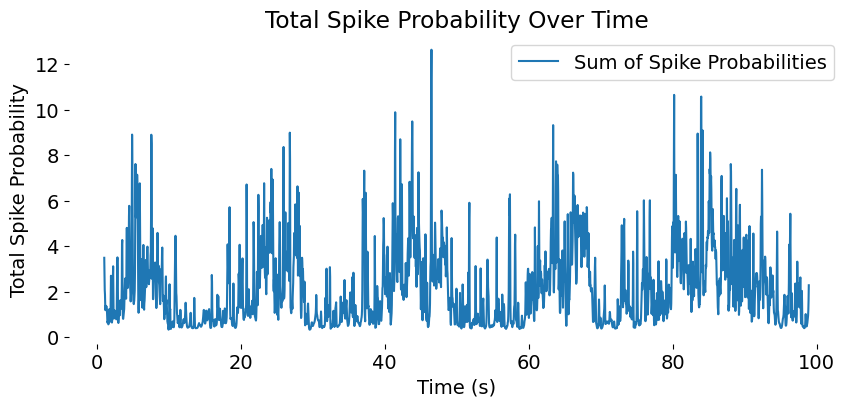

In [137]:
# plot the sum over all neurons over time
spike_probs_sum = np.sum(spike_probs, axis=0)

plt.figure(figsize=(10, 4))
plt.plot(time_vec, spike_probs_sum, label='Sum of Spike Probabilities')
plt.xlabel('Time (s)')
plt.ylabel('Total Spike Probability')
plt.title('Total Spike Probability Over Time')
plt.legend()
plt.show()

## Sorting neural traces
In the analysis of population calcium imaging or electrophysiological recordings, it is often instructive to **sort** or **reorder** neuronal traces based on some measure of their functional relationship to external variables or to population-level signals. This step serves several key purposes:

* **Pattern discovery**: Sorting can reveal structure that would be hidden in randomly-ordered or anatomically-ordered matrices—such as groups of neurons that co-activate, temporal motifs, or population-level sequences.
* **Interpretability**: By aligning traces according to their similarity with behavioral events, population dynamics, or model predictions, we facilitate interpretation and hypothesis generation.
* **Quantification**: Sorting allows us to identify and quantify subpopulations—such as neurons most strongly modulated by a task or by ongoing network events.

### Common sorting criteria and methods
Standard approaches for sorting neuronal traces include:

* **Correlation-based sorting**: Order neurons by their correlation (often Pearson’s *r*) with an external regressor, such as behavioral measurements, task epochs, or the population response itself.
* **Clustering**: Use unsupervised clustering (e.g., k-means, hierarchical, spectral clustering) to group neurons with similar activity profiles.
* **Dimensionality reduction**: Apply PCA, t-SNE, UMAP, or factor analysis to project activity into a low-dimensional space, then sort or cluster by principal components or latent states.
* **Event/time alignment**: Sort by the timing of each neuron's response to a stimulus or event of interest.

### Correlation-based sorting
In this tutorial, we will sort neurons by how well their activity matches the **smoothed or fitted population response**. This provides several important advantages over using the raw summed spike probability trace:

* **Noise reduction**: The raw sum can be highly variable due to neural and measurement noise, which may obscure the true underlying structure of network dynamics.
* **Extraction of relevant timescales**: Fitting (e.g., via Gaussian Process Regression or smoothing filters) emphasizes the timescale of coherent population events, rather than fast, idiosyncratic fluctuations of single neurons.
* **Robust correlation estimation**: Correlating each neuron’s activity with a denoised population trace yields a more meaningful measure of each neuron's contribution to global activity patterns.

By identifying the neurons whose activity is most correlated with the fitted population response, we can highlight those cells that most strongly participate in the dominant network events—such as population bursts, oscillations, or stimulus-locked responses. This process helps define the **functional core** of the recorded network.

A fast and effective way to perform this sorting is to use Savitzky-Golay smoothing, which applies a polynomial fit to the data over a sliding window. This method preserves important features while reducing noise, making it ideal for extracting the underlying population dynamics:

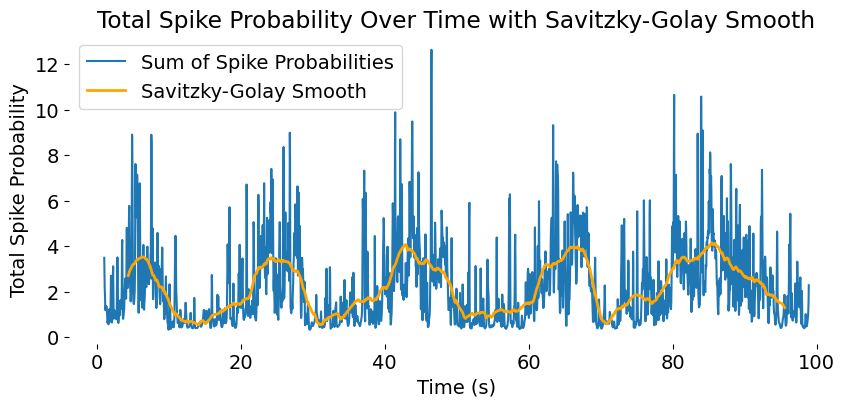

In [141]:
# Savitzky-Golay smoothing of the summed spike probabilities
from scipy.signal import savgol_filter

spike_probs_sum_smoothed = savgol_filter(spike_probs_sum, window_length=201, polyorder=2)

plt.figure(figsize=(10, 4))
plt.plot(time_vec, spike_probs_sum, label='Sum of Spike Probabilities')
plt.plot(time_vec, spike_probs_sum_smoothed, label="Savitzky-Golay Smooth", color='orange', lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Total Spike Probability')
plt.title('Total Spike Probability Over Time with Savitzky-Golay Smooth')
plt.legend()
plt.show()

### Correlating raw and smoothed population activity
After visualizing the population activity (sum of spike probabilities across all neurons), we now compare the raw and smoothed signals. Although both signals are derived from the same underlying data, smoothing emphasizes slower, more global fluctuations — removing fast noise and highlighting population-level trends.

Why compare these signals?

* **Data-driven hypotheses:**
  In real analyses, you often compare neural activity to external variables (like speed). Here, we simulate this situation by comparing the raw summed neural activity to a smoothed version, which serves as a "hypothetical" behavior or latent population state. If you later have real behavioral data, you can just substitute it in and perform the same analysis.
* **Pattern identification:**
  Smoothing can reveal underlying structure (e.g., oscillations, state transitions) not visible in the noisy raw trace. Correlating the two across time can indicate when the neural population behaves coherently (i.e., follows the slow trend) versus when it is dominated by fast, possibly unstructured activity.
* **Model validation:**
  If you later fit external variables (e.g., behavior, stimuli) to your neural data, this approach helps build intuition about the utility of smoothing and time-resolved correlations.


To assess the local similarity between raw and smoothed signals, we use a **sliding window Pearson correlation**. For each window along the time axis:

* We extract the corresponding segments from both signals.
* We calculate their Pearson correlation coefficient.
* This gives a time-resolved "correlation trace" showing how closely the fast neural activity matches the slower, smoothed population trend at each moment.

This approach highlights **when and where** the population activity is tightly linked to its slow trend—possibly reflecting network states, arousal, or artifacts—versus when it diverges.

In [ ]:

from scipy.stats import pearsonr

window_size = 100  # e.g., 100 time points (frames)
half_window = window_size // 2

# Prepare the output array (NaN for positions where window would run out of bounds)
correlation_trace = np.full(len(spike_probs_sum_smoothed), np.nan)

spike_probs_no_nan = np.nan_to_num(spike_probs, nan=0.0)  # Replace NaNs with 0 for correlation calculation
population_activity = np.sum(spike_probs_no_nan, axis=0)

for t in range(half_window, len(spike_probs_sum_smoothed) - half_window):
    # Window indices
    start = t - half_window
    end = t + half_window
    x = population_activity[start:end]
    y = spike_probs_sum_smoothed[start:end]
    if np.std(x) > 0 and np.std(y) > 0:
        correlation_trace[t] = pearsonr(x, y)[0]
    # else correlation undefined, leave as NaN

# also calculate the overall correlation
overall_correlation = pearsonr(population_activity, speed_vec)[0]
print(f'Overall correlation between population activity and speed: {overall_correlation:.2f}')



Overall correlation between population activity and speed: 0.54


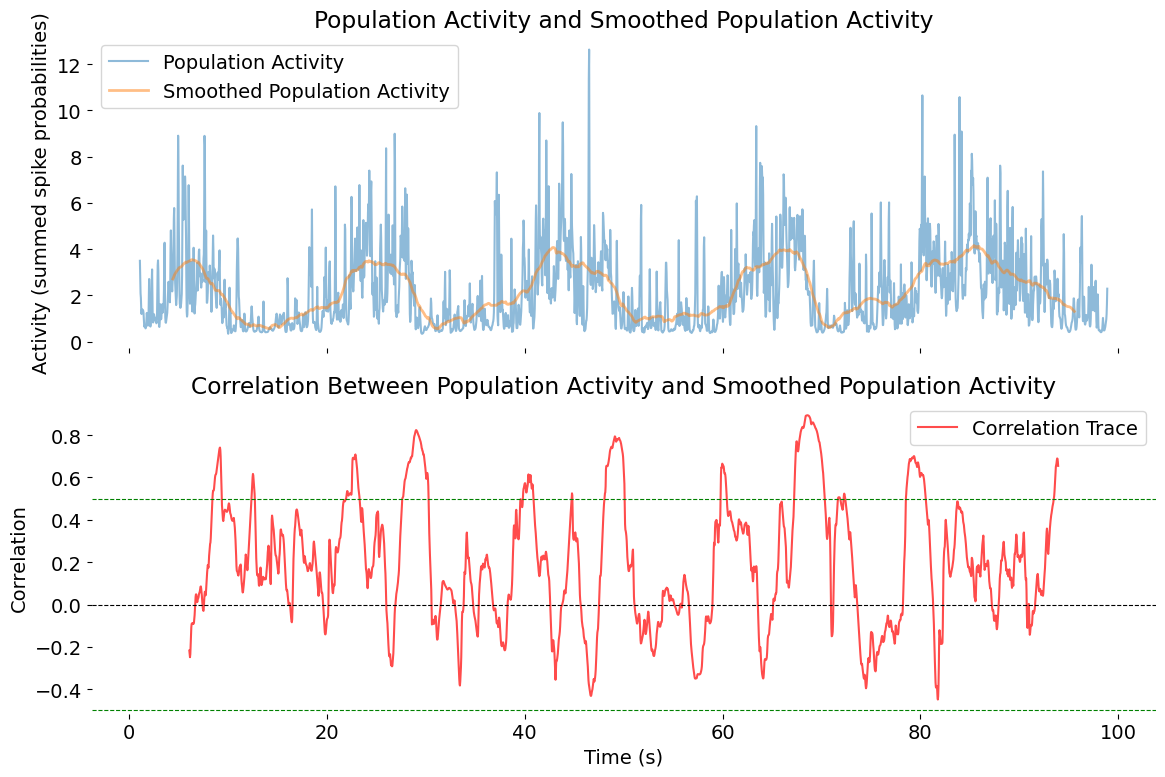

In [144]:
# plot both the population activity, the speed vector and the correlation trace
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First subplot: Population activity and speed
axs[0].plot(time_vec, np.sum(spike_probs, axis=0), label='Population Activity', alpha=0.5)
axs[0].plot(time_vec, spike_probs_sum_smoothed, label='Smoothed Population Activity', alpha=0.5, lw=2)
axs[0].set_ylabel('Activity (summed spike probabilities)')
axs[0].set_title('Population Activity and Smoothed Population Activity')
axs[0].legend()

# Second subplot: Correlation trace
axs[1].plot(time_vec, correlation_trace, label='Correlation Trace', color='red', alpha=0.7)
axs[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axs[1].axhline(0.5, color='green', linestyle='--', linewidth=0.8)
axs[1].axhline(-0.5, color='green', linestyle='--', linewidth=0.8)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Correlation')
axs[1].set_title('Correlation Between Population Activity and Smoothed Population Activity')
axs[1].legend()

plt.tight_layout()

plt.show()

**Interpreting the correlation plot:**  
* **Top panel:**
  * *Population Activity*: The sum of spike probabilities (blue), reflecting all neurons at each time point.
  * *Smoothed Population Activity*: The same signal after Savitzky-Golay filtering (orange), revealing slower, population-wide dynamics.
* **Bottom panel:**
  * The **correlation trace** quantifies the local similarity between the two signals in each time window.
  * Periods of high correlation suggest the population is moving coherently with its slow trend (perhaps reflecting network upstates, synchrony, or behavioral states).
  * Drops in correlation could indicate desynchronization, fast transients, or noise.


This type of analysis is a **first step in exploratory data analysis** of neural population recordings. It helps you:

* Detect transitions in network state.
* Identify epochs of interest for further analysis (e.g., for alignment to events, clustering, or dimensionality reduction).
* Evaluate the degree to which population dynamics are structured versus noisy.

Correlating the raw and smoothed population activity is a useful tool to characterize the temporal structure of your data, to detect network dynamics, and to build intuition for more advanced analyses—regardless of whether an explicit behavioral signal is present.


### Correlating individual neuron activity with population-level dynamics
In the next step, we explore how each neuron's activity relates to the **overall pattern of network activity over time**. To do this, we compute the **sliding window correlation** between the activity of each neuron and the smoothed population response:

* **Network contribution and functional diversity:**
  Not all neurons contribute equally or in the same way to population-level dynamics. Some may be tightly coupled to the network state, while others may behave more independently or even anti-correlated. By examining the time-resolved correlation between each neuron and the network, we can identify which neurons are “followers” of the main population dynamics and which are more independent or even oppositional.
* **Temporal specificity:**
  The relationship between single neurons and the network is often nonstationary; a neuron may be strongly correlated with the population at some times but not others. Sliding window analysis captures these dynamics.

**What we will do:**
* For each neuron, we extract its spike probability trace over time.
* For each time window (e.g., 100 frames), we calculate the Pearson correlation coefficient between the neuron’s activity and the smoothed population activity within that window.
* The result is a two-dimensional matrix: rows correspond to neurons, columns to time windows, and values to correlation strength.

In [145]:
# check the correlation between the activity of each neuron and the speed vector 
# using a sliding window approach:
window_size = 100  # number of frames per window
step = 1  # sliding step size
num_neurons, num_frames = spike_probs.shape
corr_matrix = np.zeros((num_neurons, num_frames - window_size + 1))

for neuron in range(num_neurons):
    for t in range(num_frames - window_size + 1):
        x = spike_probs[neuron, t:t+window_size]
        y = spike_probs_sum_smoothed[t:t+window_size]
        # Handle constant window (zero std): correlation undefined, set to np.nan
        if np.std(x) < 1e-10 or np.std(y) < 1e-10:
            corr_matrix[neuron, t] = np.nan
        else:
            corr_matrix[neuron, t] = np.corrcoef(x, y)[0, 1]

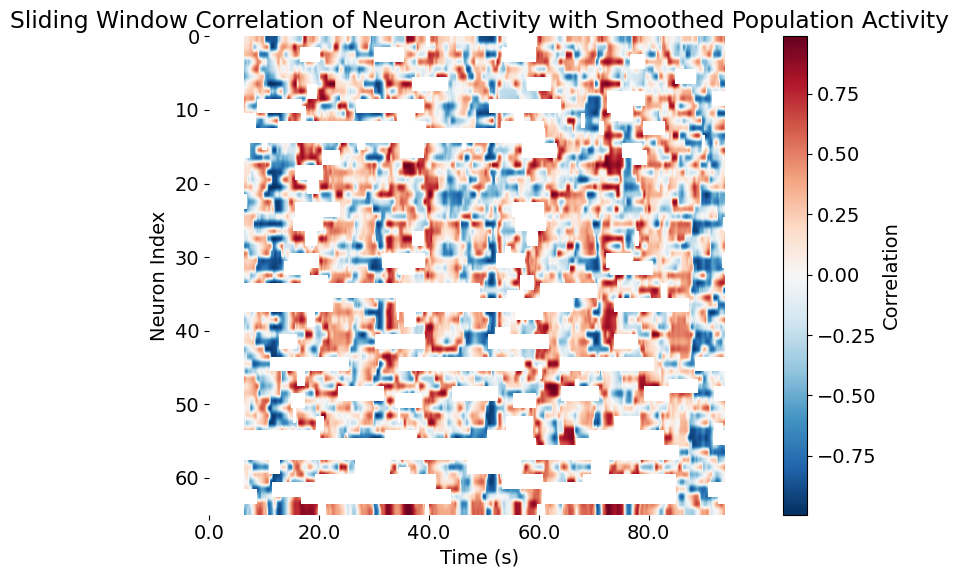

In [146]:
# plotting:
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, aspect='auto', origin='lower', cmap='RdBu_r',
           extent=[window_size/2, num_frames-window_size/2, 0, num_neurons])
plt.colorbar(label='Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Sliding Window Correlation of Neuron Activity with Smoothed Population Activity')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(0, spike_probs.shape[1], frame_rate * 20), 
           labels=np.arange(0, spike_probs.shape[1] / frame_rate, 20))
plt.tight_layout()
plt.show()

Interpreting the resulting correlation matrix:

* The resulting **correlation matrix** (visualized as a heatmap) reveals complex, time-varying relationships between each neuron and the population state.
* **Bright red** (positive correlation) indicates periods when a neuron’s activity rises and falls in concert with the overall network.
* **Blue** (negative correlation) indicates periods of anti-correlation: when the neuron is active, the population is quiet, or vice versa.
* **White or neutral** regions suggest little or no linear relationship in that window.
* Temporal fluctuations in these patterns can reveal:
  * Dynamical changes in network membership (e.g., “assembly” formation and dissolution),
  * State transitions,
  * Functional subpopulations,
  * Artifacts or noise.


This analysis is a **foundational tool** in systems neuroscience for:
* Identifying network "hubs" or key integrators,
* Detecting functionally defined cell assemblies,
* Exploring how neuronal synchrony evolves with behavior or state,
* Guiding further dimensionality reduction or clustering.


### Sorting neurons
In this final analysis step, we sort neurons **by the strength of their correlation with the smoothed summed spike probability (i.e., the global population activity vector)**. This approach highlights which neurons most closely follow the overall population dynamics and allows us to visualize functional structure in the data.

**What are the benefits of this sorting:**
* **Identify key contributors:**
  Neurons whose activity is highly correlated with the population signal are likely to be principal contributors to global network events or “assemblies.” Sorting makes these relationships directly visible.
* **Expose diversity in participation:**
  The sorted matrix will display gradients or clusters, showing which neurons are most, least, or even anti-correlated with the overall network activity.
* **Enhance interpretability:**
  Ordered matrices reveal coordinated motifs and can help distinguish global versus specialized patterns of network participation.

**What we will do:**
* For each neuron, compute the Pearson correlation coefficient between its spike probability time series and the smoothed summed population activity (not the behavior or speed).
* Sort all neurons in descending order by this correlation value.
* Visualize the spike probability matrix and sliding window correlation matrix using this sorted neuron order.

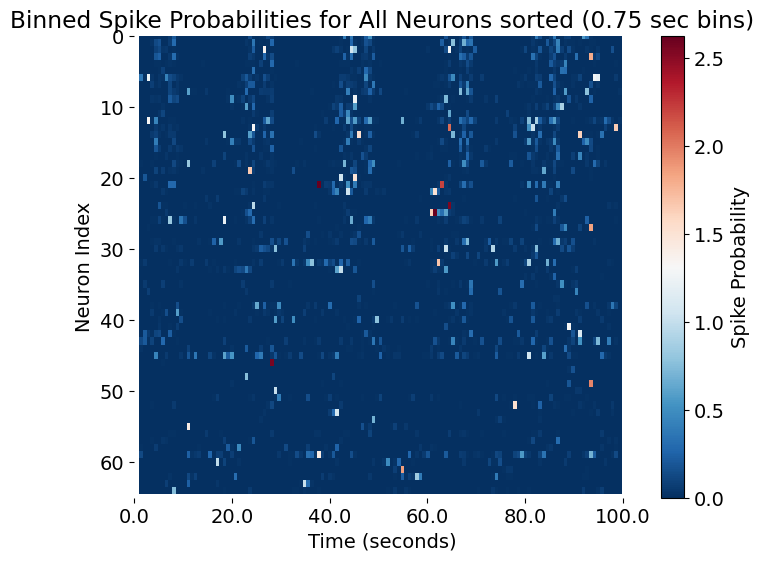

In [150]:
# get a correlation index for each neuron, i.e., correlate the speed vector with the activity of each neuron in spike_probs:
spike_probs_no_nan = np.nan_to_num(spike_probs, nan=0.0)  # Replace NaNs with 0 for correlation calculation
spike_probs_sum_smoothed = np.nan_to_num(spike_probs_sum_smoothed, nan=0.0)  # Replace NaNs with 0 for correlation calculation
overall_correlation_per_neuron = np.zeros(num_neurons)
for neuron in range(num_neurons):
    overall_correlation_per_neuron[neuron] = pearsonr(spike_probs_no_nan[neuron], spike_probs_sum_smoothed)[0]
    
# sort overall_correlation_per_neuron in descending order and sort the rows in spike_probs accordingly:
sorted_indices = np.argsort(overall_correlation_per_neuron)[::-1]
sorted_spike_probs = spike_probs[sorted_indices]

# plot the same plot as above, but no binned for every N seconds
bin_size = 0.75  # in sec - please change this to your desired bin size

# convert bin size to number of frames:
bin_size_frames = int(bin_size * frame_rate)  # convert to number of frames
# bin the spike probabilities:
sorted_spike_probs_binned = sorted_spike_probs[:, ::bin_size_frames]
plt.figure(figsize=(8, 6))
plt.imshow(sorted_spike_probs_binned, aspect='auto', cmap='RdBu_r', origin='lower')
plt.colorbar(label='Spike Probability')
plt.title(f'Binned Spike Probabilities for All Neurons sorted ({bin_size} sec bins)')
plt.xlim(0, sorted_spike_probs_binned.shape[1])
plt.ylim(0, sorted_spike_probs_binned.shape[0])
plt.gca().invert_yaxis()
# change the x-axis ticks to show time in seconds
plt.xticks(ticks=np.arange(0, sorted_spike_probs_binned.shape[1], frame_rate * 20 // bin_size_frames), 
           labels=np.arange(0, sorted_spike_probs_binned.shape[1] * bin_size_frames / frame_rate, 20))
plt.xlabel('Time (seconds)')
plt.ylabel('Neuron Index')
#plt.tight_layout()
plt.show()


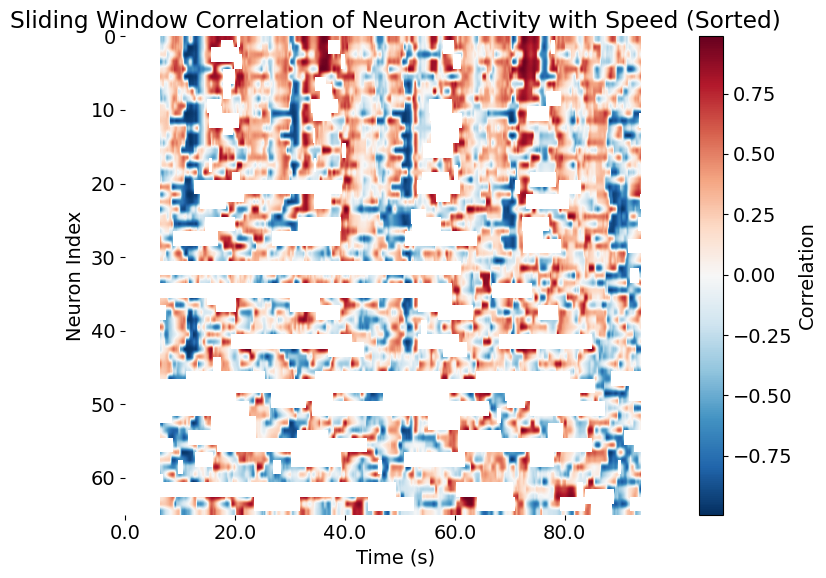

In [151]:
# sort and plot also corr_matrix again:
sorted_corr_matrix = corr_matrix[sorted_indices]
plt.figure(figsize=(8, 6))
plt.imshow(sorted_corr_matrix, aspect='auto', origin='lower', cmap='RdBu_r',
           extent=[window_size/2, num_frames-window_size/2, 0, num_neurons])
plt.colorbar(label='Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Sliding Window Correlation of Neuron Activity with Speed (Sorted)')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(0, spike_probs.shape[1], frame_rate * 20), 
           labels=np.arange(0, spike_probs.shape[1] / frame_rate, 20))
plt.tight_layout()
plt.show()  

**Interpretation:**
* **Top rows**: Neurons with the highest synchrony to the network's global activity.
* **Bottom rows**: Neurons less involved in, or even opposed to, the dominant population dynamics.
* This ordering can uncover "core" and "peripheral" neurons in the functional population, as well as potential sub-populations with specialized roles.

Sorting neurons by their correlation with the smoothed population activity provides an efficient way to detect and visualize functional hierarchies, assemblies, or gradients within the recorded network. It is a key exploratory tool in population neuroscience, particularly when linking single-cell and collective dynamics.


## Conclusion and perspective
In this tutorial, we have developed a complete analysis pipeline for exploring neural population activity derived from calcium imaging data. Starting from pre-processed spike probability estimates, we visualized and quantified activity patterns at the single-neuron and population level, utilized dimensionality reduction and smoothing techniques, and performed both global and local (sliding window) correlation analyses to reveal functional structure within the dataset.

A key methodological step was sorting the neural activity matrix according to each neuron's correlation with the smoothed population activity. This approach made it possible to identify "core" neurons most closely aligned with network-level events, as well as to visualize the diversity and temporal evolution of neural participation in global dynamics.

While in this tutorial we focused on internal network signals (population activity vectors) as the main reference for sorting and correlation, the **integration of behavioral vectors** — such as movement speed, direction, or task-relevant features—offers a direct path to uncovering brain-behavior relationships. By substituting or supplementing the population activity with externally measured behavioral data, the same analysis pipeline can be applied to:

* Quantify the degree to which individual neurons or ensembles are modulated by behavior.
* Identify functional cell assemblies that are specifically engaged during particular actions, stimuli, or task epochs.
* Reveal lags or leads between neural and behavioral signals, supporting causal or predictive modeling.
* Compare the structure of neural population activity with the external world, going beyond purely intrinsic network dynamics.

**Perspective:**  
The ability to flexibly align and correlate neural data with both population and behavioral signals is essential for modern systems neuroscience. It enables the transition from descriptive network analysis toward mechanistic insights into neural coding and computation. As an immediate next step, students are encouraged to integrate real behavioral vectors (when available) into this framework, repeating the analyses and comparing the organization and engagement of the network under different behavioral or experimental conditions.


**In summary**, the analysis methods introduced here form a foundation for exploratory and hypothesis-driven studies in functional imaging data, providing robust strategies for linking cellular activity, population dynamics, and behavior.

## Exercise: Integrating (toy) behavioral data – A practical demonstration
In this final section, we illustrate how to incorporate externally measured behavioral data — such as that extracted with DeepLabCut — into our population analysis workflow. For demonstration purposes, we provide a *toy* behavior vector, which in this case is derived directly from the summed population activity, but temporally shifted by a few seconds. This ensures that the analysis code and its logic are transparent and reproducible, even in the absence of actual behavioral recordings.

**Purpose and Limitations:**
* The main goal here is to familiarize you with the practical steps needed to load, handle, and integrate a behavioral data vector into your analysis pipeline.
* Note that, since the toy vector is mathematically constructed from the neural data itself (albeit phase-shifted), the correlations and patterns you observe will largely recapitulate the results obtained above.
* Once you have your own behavioral recordings available (e.g., tracking data from DeepLabCut, speed traces, or task events), you can simply replace the file path and column selections to repeat all subsequent analyses with genuine behavioral variables.

**Generalization:**
This exercise is designed to be easily adaptable. The key operations—alignment, correlation, visualization, and sorting—remain the same regardless of the behavioral vector used. Thus, all analytical techniques shown here for the toy vector will apply identically to real experimental data, allowing you to robustly link neuronal activity to behavior in your own research.

While the present example uses a toy (simulated) behavior vector for demonstration purposes, the workflow provides a direct template for integrating genuine behavioral data into neural population analyses. This flexibility is essential for understanding the neural basis of behavior and for extending your analyses to more complex, hypothesis-driven experiments.

Load the example file `fake_behavior_data_Sue_2x_3000_40_-46.csv`, which contains simulated behavioral data specifically constructed to align with the neuronal dataset analyzed in this tutorial. This *fake* behavior vector is phase-shifted and scaled to mimic a plausible correspondence between movement and neural activity, providing a stand-in for genuine behavioral measurements:

In [96]:
behavior_data_path = '../03 Linking Behavior and Neuronal Activity/'
behavior_data_file = 'fake_behavior_data_Sue_2x_3000_40_-46.csv'  # please change this to your own file
behavior_data_fullpath = behavior_data_path + behavior_data_file
behavior_data = pd.read_csv(behavior_data_fullpath, index_col=0, header=[0,1,2])

Let's inspect the first few rows of the data to understand its structure:

In [97]:
behavior_data

scorer    DLC_resnet50_BehaviorJul7                     
bodyparts            paw_front_left                     
coords                            x         y likelihood
0                         -0.343244  0.345234       0.99
1                          0.504582 -0.161449       0.99
2                         -0.064743 -0.569818       0.99
3                         -0.502866 -0.358917       0.99
4                          0.368948  0.550436       0.99
...                             ...       ...        ...
2995                       0.000000 -0.000000       0.99
2996                       0.000000  0.000000       0.99
2997                      -0.000000  0.000000       0.99
2998                      -0.000000  0.000000       0.99
2999                       0.000000 -0.000000       0.99

[3000 rows x 3 columns]

Here is how you can access the x and y coordinates of the tracked bodypart (here: "paw_front_left"):

In [99]:
x = behavior_data[('DLC_resnet50_BehaviorJul7', 'paw_front_left', 'x')]
y = behavior_data[('DLC_resnet50_BehaviorJul7', 'paw_front_left', 'y')]
x

0      -0.343244
1       0.504582
2      -0.064743
3      -0.502866
4       0.368948
          ...   
2995    0.000000
2996    0.000000
2997   -0.000000
2998   -0.000000
2999    0.000000
Name: (DLC_resnet50_BehaviorJul7, paw_front_left, x), Length: 3000, dtype: float64

Since we have both the x and y coordinates, we can compute the Euclidean distance of the tracked body part from its initial position. This gives us a measure of movement that is more informative than just one coordinate:

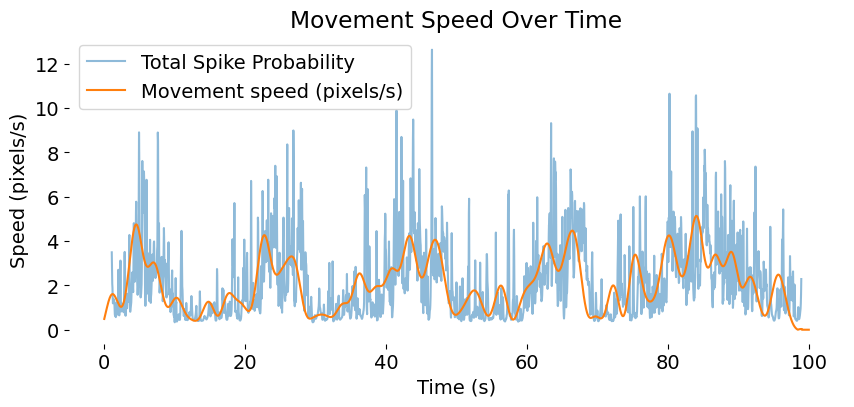

In [105]:
speed_vec = np.sqrt(x**2 + y**2)

plt.figure(figsize=(10, 4))
plt.plot(time_vec, np.sum(spike_probs, axis=0), label='Total Spike Probability', alpha=0.5)
plt.plot(time_vec, np.sqrt(x**2 + y**2), label='Movement speed (pixels/s)')
plt.xlabel('Time (s)')
plt.ylabel('Speed (pixels/s)')
plt.title('Movement Speed Over Time')
plt.legend()
plt.show()

Now, we repeat the same analysis steps as before. Thus, we begin by calculating the correlation(s):

In [116]:
from scipy.stats import pearsonr

window_size = 100  # e.g., 100 time points (frames)
half_window = window_size // 2

# Prepare the output array (NaN for positions where window would run out of bounds)
correlation_trace = np.full(len(speed_vec), np.nan)

spike_probs_no_nan = np.nan_to_num(spike_probs, nan=0.0)  # Replace NaNs with 0 for correlation calculation
population_activity = np.sum(spike_probs_no_nan, axis=0)

for t in range(half_window, len(speed_vec) - half_window):
    # Window indices
    start = t - half_window
    end = t + half_window
    x = population_activity[start:end]
    y = speed_vec[start:end]
    if np.std(x) > 0 and np.std(y) > 0:
        correlation_trace[t] = pearsonr(x, y)[0]
    # else correlation undefined, leave as NaN

# also calculate the overall correlation
overall_correlation = pearsonr(population_activity, speed_vec)[0]
print(f'Overall correlation between population activity and speed: {overall_correlation:.2f}')

Overall correlation between population activity and speed: 0.54


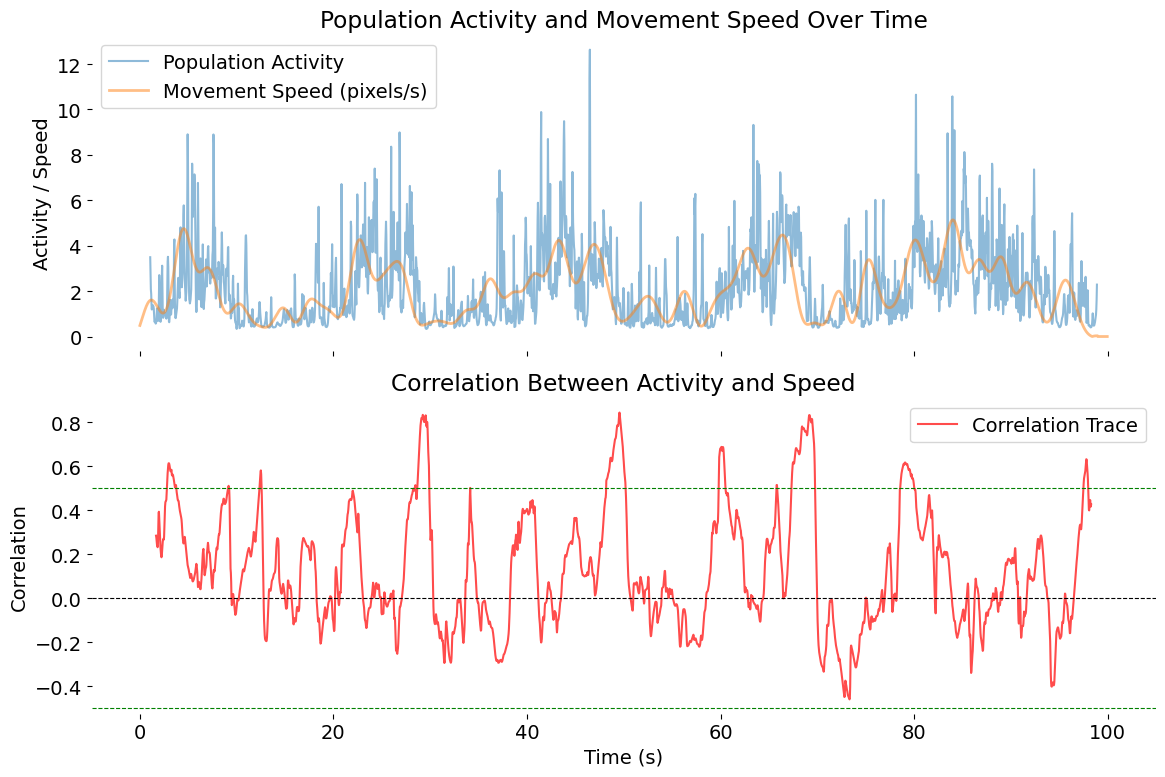

In [115]:
# plot both the population activity, the speed vector and the correlation trace
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First subplot: Population activity and speed
axs[0].plot(time_vec, np.sum(spike_probs, axis=0), label='Population Activity', alpha=0.5)
axs[0].plot(time_vec, speed_vec, label='Movement Speed (pixels/s)', alpha=0.5, lw=2)
axs[0].set_ylabel('Activity / Speed')
axs[0].set_title('Population Activity and Movement Speed Over Time')
axs[0].legend()

# Second subplot: Correlation trace
axs[1].plot(time_vec, correlation_trace, label='Correlation Trace', color='red', alpha=0.7)
axs[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axs[1].axhline(0.5, color='green', linestyle='--', linewidth=0.8)
axs[1].axhline(-0.5, color='green', linestyle='--', linewidth=0.8)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Correlation')
axs[1].set_title('Correlation Between Activity and Speed')
axs[1].legend()

plt.tight_layout()



Then we check for correlation between the "speed vector" and individual neurons:

In [132]:
# check the correlation between the activity of each neuron and the speed vector 
# using a sliding window approach:
window_size = 100  # number of frames per window
step = 1  # sliding step size
num_neurons, num_frames = spike_probs.shape
corr_matrix = np.zeros((num_neurons, num_frames - window_size + 1))

for neuron in range(num_neurons):
    for t in range(num_frames - window_size + 1):
        x = spike_probs[neuron, t:t+window_size]
        y = speed_vec[t:t+window_size]
        # Handle constant window (zero std): correlation undefined, set to np.nan
        if np.std(x) < 1e-10 or np.std(y) < 1e-10:
            corr_matrix[neuron, t] = np.nan
        else:
            corr_matrix[neuron, t] = np.corrcoef(x, y)[0, 1]

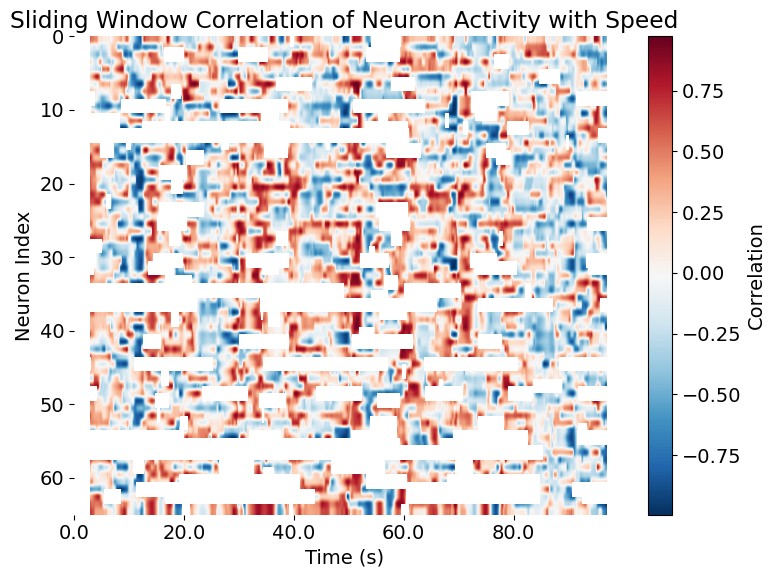

In [ ]:
# plotting:
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, aspect='auto', origin='lower', cmap='RdBu_r',
           extent=[window_size/2, num_frames-window_size/2, 0, num_neurons])
plt.colorbar(label='Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Sliding Window Correlation of Neuron Activity with Speed')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(0, spike_probs.shape[1], frame_rate * 20), 
           labels=np.arange(0, spike_probs.shape[1] / frame_rate, 20))
plt.tight_layout()
plt.show()

And then we sort the neurons by their correlation with the speed vector:

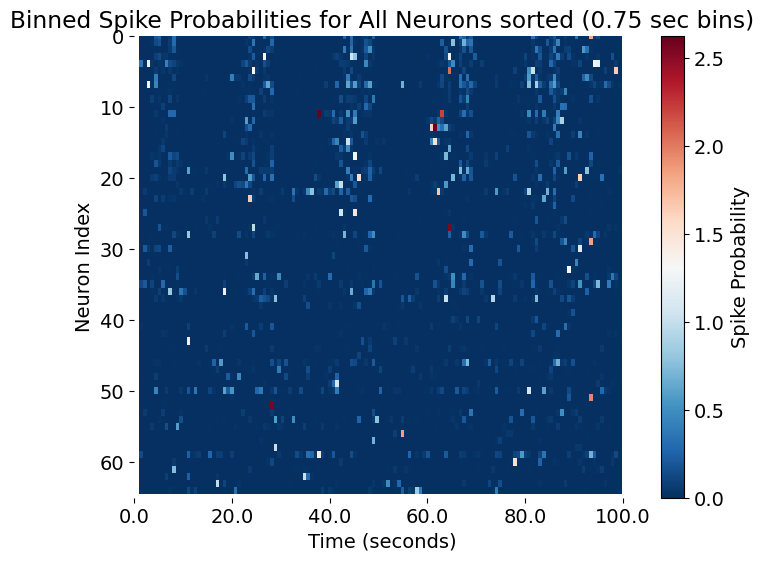

In [ ]:
# get a correlation index for each neuron, i.e., correlate the speed vector with the activity of each neuron in spike_probs:
overall_correlation_per_neuron = np.zeros(num_neurons)
for neuron in range(num_neurons):
    overall_correlation_per_neuron[neuron] = pearsonr(spike_probs_no_nan[neuron], speed_vec)[0]
    
# sort overall_correlation_per_neuron in descending order and sort the rows in spike_probs accordingly:
sorted_indices = np.argsort(overall_correlation_per_neuron)[::-1]
sorted_spike_probs = spike_probs[sorted_indices]

# plot the same plot as above, but no binned for every N seconds
bin_size = 0.75  # in sec - please change this to your desired bin size

# convert bin size to number of frames:
bin_size_frames = int(bin_size * frame_rate)  # convert to number of frames
# bin the spike probabilities:
sorted_spike_probs_binned = sorted_spike_probs[:, ::bin_size_frames]
plt.figure(figsize=(8, 6))
plt.imshow(sorted_spike_probs_binned, aspect='auto', cmap='RdBu_r', origin='lower')
plt.colorbar(label='Spike Probability')
plt.title(f'Binned Spike Probabilities for All Neurons sorted ({bin_size} sec bins)')
plt.xlim(0, sorted_spike_probs_binned.shape[1])
plt.ylim(0, sorted_spike_probs_binned.shape[0])
plt.gca().invert_yaxis()
# change the x-axis ticks to show time in seconds
plt.xticks(ticks=np.arange(0, sorted_spike_probs_binned.shape[1], frame_rate * 20 // bin_size_frames), 
           labels=np.arange(0, sorted_spike_probs_binned.shape[1] * bin_size_frames / frame_rate, 20))
plt.xlabel('Time (seconds)')
plt.ylabel('Neuron Index')
#plt.tight_layout()
plt.show()


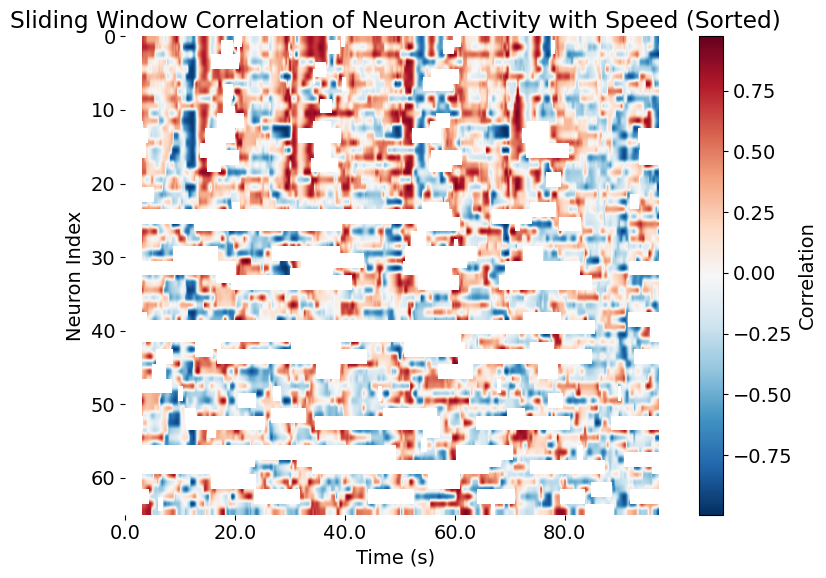

In [135]:
# sort and plot also corr_matrix again:
sorted_corr_matrix = corr_matrix[sorted_indices]
plt.figure(figsize=(8, 6))
plt.imshow(sorted_corr_matrix, aspect='auto', origin='lower', cmap='RdBu_r',
           extent=[window_size/2, num_frames-window_size/2, 0, num_neurons])
plt.colorbar(label='Correlation')
plt.xlabel('Time (s)')
plt.ylabel('Neuron Index')
plt.title('Sliding Window Correlation of Neuron Activity with Speed (Sorted)')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(0, spike_probs.shape[1], frame_rate * 20), 
           labels=np.arange(0, spike_probs.shape[1] / frame_rate, 20))
plt.tight_layout()
plt.show()  

**Exercise:** Load, if at hand, your own DeepLabCut or other behavioral data, and repeat the analysis steps shown above. Specifically, compute the speed vector, calculate correlations with the summed spike probabilities, and sort neurons accordingly. This will allow you to explore how well your neural data aligns with behavioral variables in your own experiments.